In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate_multiple

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data[f'ema_{periods}'] = data.ema_diff / vol 
    return data[f'ema_{periods}']

In [3]:
def reducer(x):
    if x < -2.7:
        return max(-(np.log(np.abs(x) -2.7) - .5), 0)
    elif x > 2.7:
        return min((np.log(np.abs(x) -2.7) - .5), 0)
    else:
        return - x**3

In [4]:
def bolli(data, periods, smooth, vol):
    data = data.copy()
    data['mid'] = data.close.ewm(span=periods).mean()
    data['distance'] = data.mid - data.close
    data['std'] = data.close.ewm(span=periods).std()
    data['distance_scaled'] = data.distance / data['std']
    data[f'bolli_{periods}'] = data['distance_scaled']
    return data[f'bolli_{periods}']

In [5]:
def bolli_reduced(data, periods, smooth, vol):
    data = data.copy()
    data[f'bolli_reduced_{periods}'] = smooth(bolli(data, periods, smooth, vol).apply(reducer), periods/3)
    #data[f'bolli_reduced_{periods}'] = bolli(data, periods, smooth, vol).apply(reducer)
    return data[f'bolli_reduced_{periods}']

In [6]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [7]:
def carver(data, periods, smooth, vol):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = smooth(data['breakout_norm'], periods/3)
    return data[f'carver_{periods}']

In [8]:
def roc(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.pct_change(periods) * 100
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc']
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [9]:
def roca(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.diff()
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc'] / vol
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [10]:
sym = 'NQ'
start_date = '20190701'
end_date='20191231'
periods=[40,]
breakout_periods=[20]
carver_periods=[10,20,40,80,160]
roc_periods = [5,10,20,40]
s='20180501'
params = {
    'bolli_reduced': calibrate_multiple(sym, bolli_reduced, start_date=s),
    'ema': calibrate_multiple(sym, ema, start_date=s, periods=periods),
    'breakout': calibrate_multiple(sym, breakout, start_date=s, periods=breakout_periods),
    'carver': calibrate_multiple(sym, carver, start_date=s, periods=carver_periods, adjustment=40),
    'roc': calibrate_multiple(sym, roc, start_date=s, periods=roc_periods),
    'roca': calibrate_multiple(sym, roca, start_date=s),
}

inds = {
    #'bolli_reduced': simulate(params['bolli_reduced'], sym, bolli_reduced, start_date=start_date, end_date=end_date, periods=periods), 
    'ema': simulate(params['ema'], sym, ema, start_date=start_date, end_date=end_date, periods=periods), 
    #'breakout': simulate(params['breakout'], sym, breakout, start_date=start_date, end_date=end_date, periods=breakout_periods),
    'carver': simulate(params['carver'], sym, carver, start_date=start_date, end_date=end_date, periods=carver_periods, adjustment=40),
    #'roc': simulate(params['roc'], sym, roc, start_date=start_date, end_date=end_date, periods=roc_periods),
    #'roca': simulate(params['roca'], sym, roca, start_date=start_date, end_date=end_date, periods=periods),
}
weights = {
    'bollir': .5, 
    'ema': .25, 
    'breakout': .25,
    #'carver': .1,
    #'roc': .1,
}


In [11]:
out = pd.DataFrame(columns=['mean', 'std'])
for key, ind in inds.items():
    out.loc[key, 'mean'] = ind.forecast.abs().mean()
    out.loc[key, 'std'] = ind.forecast.abs().std()
out

,mean,std
ema,9.2048,6.34855
carver,8.37821,5.47923


In [12]:
c=pd.DataFrame({key: ind.forecast for key, ind in inds.items()}).corr()
c

,ema,carver
ema,1.000000,0.682247
carver,0.682247,1.000000


In [13]:
c.sum()

ema       1.682247
carver    1.682247
dtype: float64

In [14]:
def combine(inds, weights=None):
    if weights is None:
        weights = {key: 1/len(inds) for key in inds.keys()}
    assert round(sum(weights.values()),4) == 1.0, "Weights don't add up to 1"
    df = pd.DataFrame({name: df.forecast for name, df in inds.items()}).dropna()
    df['forecast'] = (df*pd.Series(weights)).sum(axis=1)
    df[['open', 'close']] = inds[list(inds.keys())[0]][['open', 'close']]
    #multiplier = 10/df.forecast.abs().std()
    multiplier = 1
    df['forecast'] = df.forecast * multiplier
    return df.dropna()

In [15]:
data=combine(inds,)

In [16]:
data.forecast.abs().mean(), data.forecast.abs().std()

(8.138936371405531, 5.479780147008369)

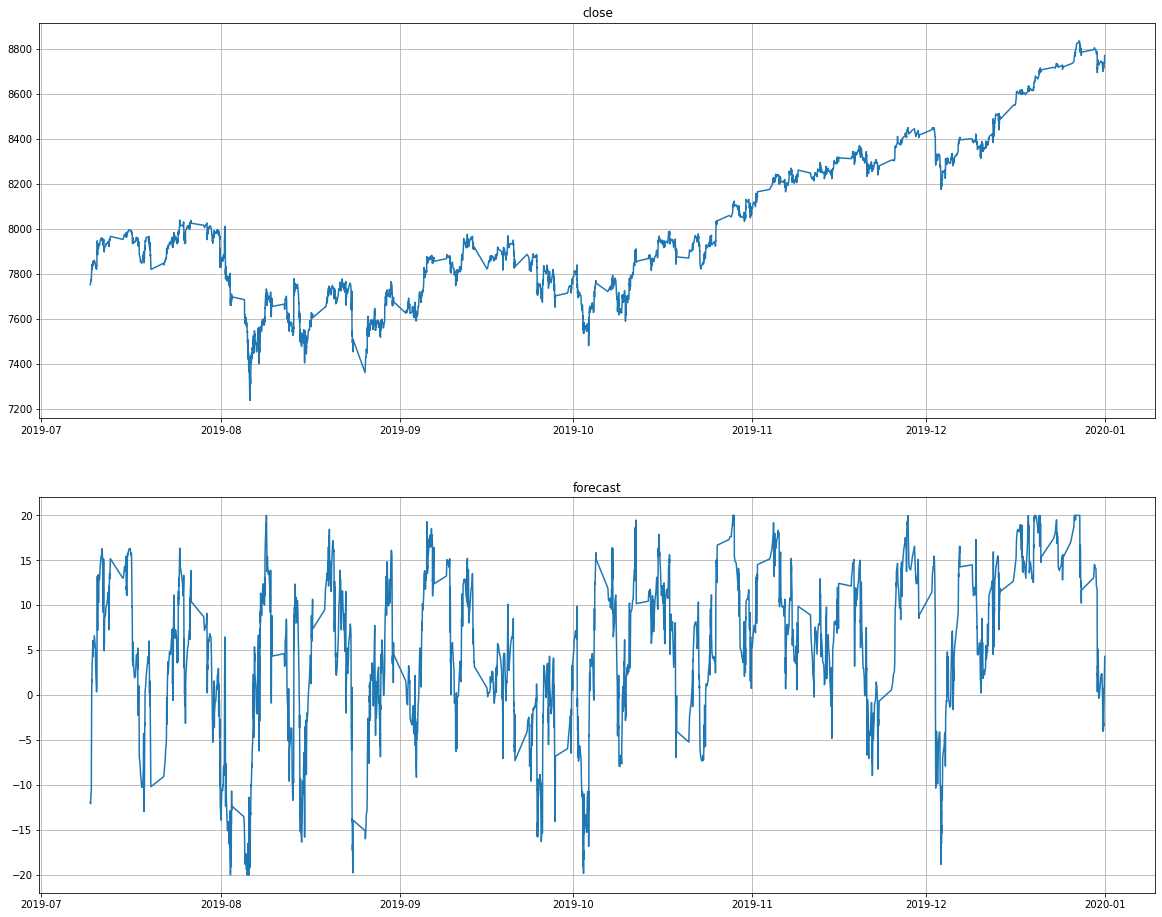

In [17]:
plot(data[['close', 'forecast']])

In [18]:
out = summary(data, slip=1.5)
out.stats

,0,3,5,6,7,10,15,17,19
Annual return,-0.155809,-0.118959,-0.131902,-0.0200041,0.0347044,0.0563396,-0.103443,0.0200808,-0.0128384
Cumulative returns,-0.0805838,-0.0608902,-0.0677589,-0.0099732,0.0170665,0.0275603,-0.0527228,0.0099108,-0.00638901
Annual volatility,0.144076,0.128466,0.128405,0.116242,0.115264,0.0895883,0.0735858,0.0398842,0.0214175
Sharpe ratio,-1.10385,-0.92221,-1.03785,-0.11654,0.352865,0.655891,-1.44741,0.518134,-0.592678
Calmar ratio,-1.01704,-0.879452,-1.17837,-0.289699,0.577252,1.52923,-1.05676,0.849976,-0.545571
Stability,0.618721,0.461643,0.731181,0.152683,0.033544,0.28096,0.819596,0.0522194,0.696022
Max drawdown,-0.153199,-0.135265,-0.111936,-0.0690515,-0.06012,-0.0368419,-0.097887,-0.0236251,-0.0235321
Omega ratio,0.832276,0.859413,0.83717,0.979557,1.07048,1.1535,0.655765,1.23225,0.780778
Sortino ratio,-1.52312,-1.40845,-1.54387,-0.194831,0.591754,1.27616,-2.352,1.09555,-0.817444
Skew,0.346406,1.02267,0.881471,1.35628,1.11665,2.44118,3.21862,4.77823,-0.0481776


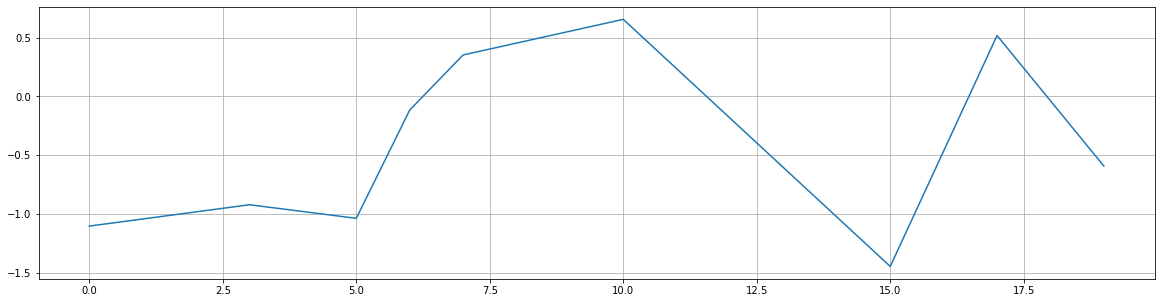

In [19]:
out.stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [20]:
out.returns.corr()

,0,3,5,6,7,10,15,17,19
0,1.000000,0.886175,0.752532,0.749894,0.716982,0.647226,0.451972,0.434916,0.249804
3,0.886175,1.000000,0.887003,0.869931,0.810402,0.733551,0.512318,0.471742,0.251046
5,0.752532,0.887003,1.000000,0.958674,0.921356,0.769599,0.561149,0.476552,0.254265
6,0.749894,0.869931,0.958674,1.000000,0.948076,0.802249,0.559042,0.494271,0.241180
7,0.716982,0.810402,0.921356,0.948076,1.000000,0.836136,0.587647,0.502094,0.257816
10,0.647226,0.733551,0.769599,0.802249,0.836136,1.000000,0.716918,0.609528,0.321366
15,0.451972,0.512318,0.561149,0.559042,0.587647,0.716918,1.000000,0.806433,0.503099
17,0.434916,0.471742,0.476552,0.494271,0.502094,0.609528,0.806433,1.000000,0.721214
19,0.249804,0.251046,0.254265,0.241180,0.257816,0.321366,0.503099,0.721214,1.000000


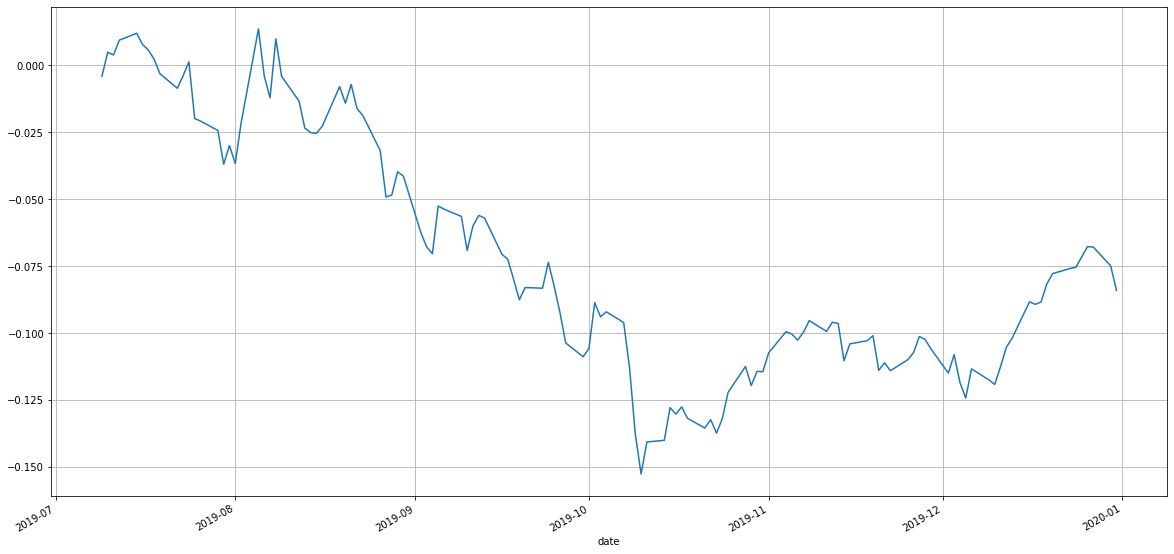

In [21]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

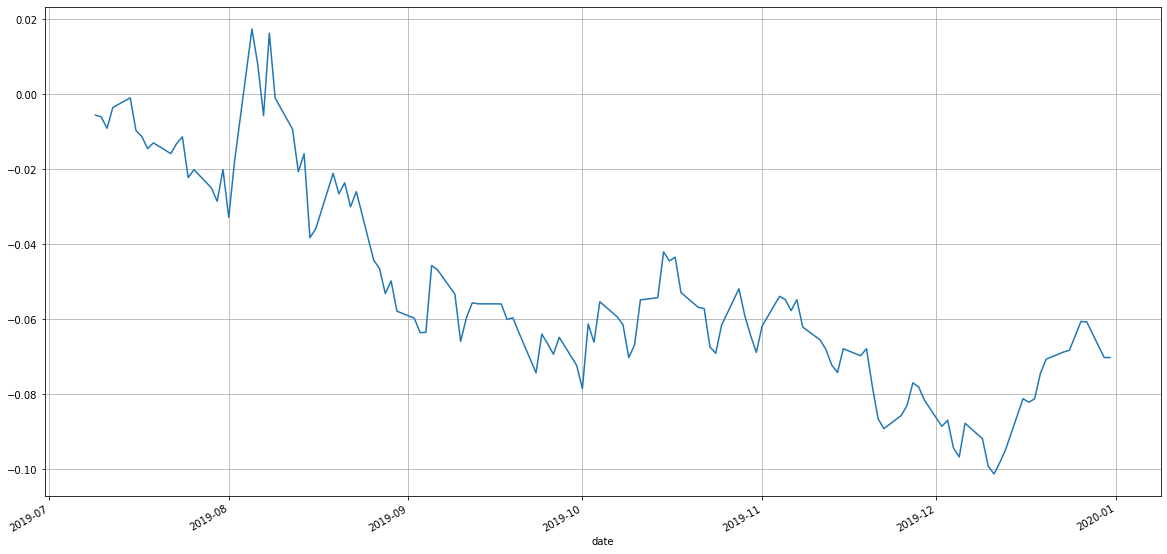

In [22]:
np.log(out.returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

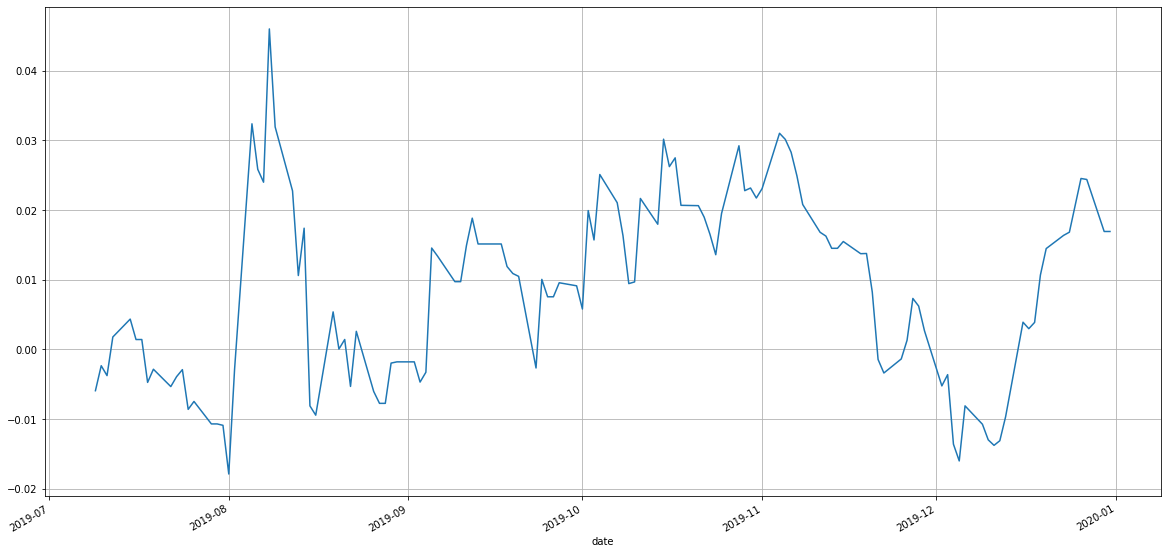

In [23]:
np.log(out.returns[7]+1).cumsum().plot(figsize=(20, 10), grid=True);

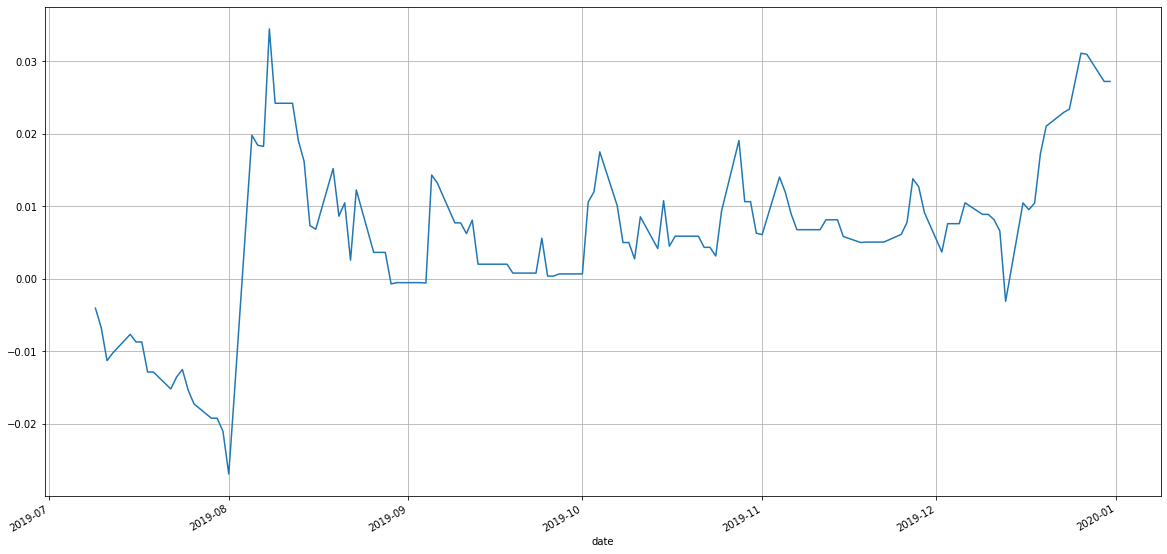

In [24]:
np.log(out.returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);

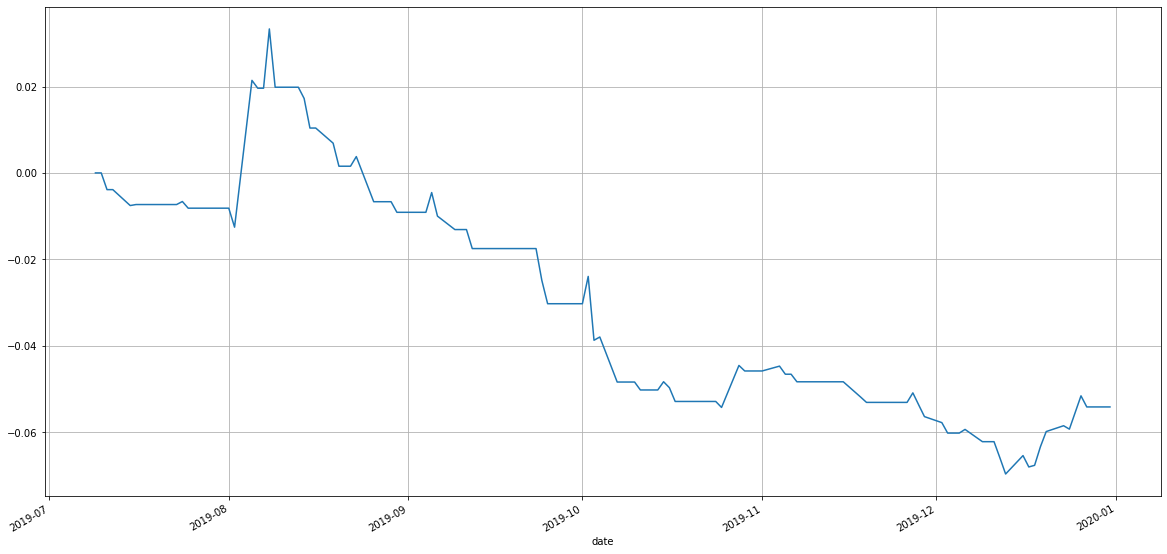

In [25]:
np.log(out.returns[15]+1).cumsum().plot(figsize=(20, 10), grid=True);